In [48]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split


In [84]:
df = pd.read_csv("D:/КУРСЫ/GeekBrains/Maching_learning/Lection4/data.csv")
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [85]:
df.loc[(df.offer != 'No Offer'), 'offer'] = 1
df.loc[(df.offer == 'No Offer'), 'offer'] = 0
df['offer'].describe()

count     64000
unique        2
top           1
freq      42694
Name: offer, dtype: int64

In [86]:
df.rename(columns = {'conversion':'target', 'offer':'treatment'}, inplace = True )
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [87]:
x = [i for i in range(64000)]
df["client_id"] = x
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,client_id
0,10,142.44,1,0,Surburban,0,Phone,1,0,0
1,6,329.08,1,1,Rural,1,Web,0,0,1
2,7,180.65,0,1,Surburban,1,Web,1,0,2
3,9,675.83,1,0,Rural,1,Web,1,0,3
4,2,45.34,1,0,Urban,0,Web,1,0,4


In [88]:
df.loc[(df.zip_code == 'Surburban'), 'zip_code'] = 1
df.loc[(df.zip_code == 'Rural'), 'zip_code'] = 0
df.loc[(df.zip_code == 'Urban'), 'zip_code'] = 2
df['zip_code'].describe()

count     64000
unique        3
top           1
freq      28776
Name: zip_code, dtype: int64

In [89]:
df.loc[(df.channel == 'Web'), 'channel'] = 1
df.loc[(df.channel == 'Phone'), 'channel'] = 0
df.loc[(df.channel == 'Multichannel'), 'channel'] = 2
df['channel'].describe()

count     64000
unique        3
top           1
freq      28217
Name: channel, dtype: int64

In [90]:
Train_full, test_full, Train_target, test_target = train_test_split(df.drop(['target'], axis=1), df.target, test_size=0.1, stratify=df.target, random_state=42)
df_train_full = pd.concat([Train_full, Train_target], axis=1)
df_test_full = pd.concat([test_full, test_target], axis=1)
df_test_full.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,client_id,target
51442,1,44.44,1,0,2,0,1,1,51442,0
43858,6,332.03,1,1,2,0,1,1,43858,0
6211,1,165.36,0,1,2,0,1,1,6211,0
31803,7,66.36,1,0,2,1,0,1,31803,0
30885,1,244.58,1,0,2,1,0,0,30885,0


In [94]:
df_train = df_train_full[["client_id", "treatment", "target"]]
df_test = df_test_full[["client_id", "treatment", "target"]]
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)
features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code', 'channel']
df_features = df[features]

In [95]:
#df_train = df[["client_id", "treatment", "target"]]
#indices_train = df_train.index
#indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)
#features = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code', 'channel']
#df_features = df[features]

In [110]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df_features.loc[indices_test, :]

cat_features = ['used_discount', 'used_bogo', 'is_referral']

models_results = {
    'approach': [],
    'uplift@30%': []
}

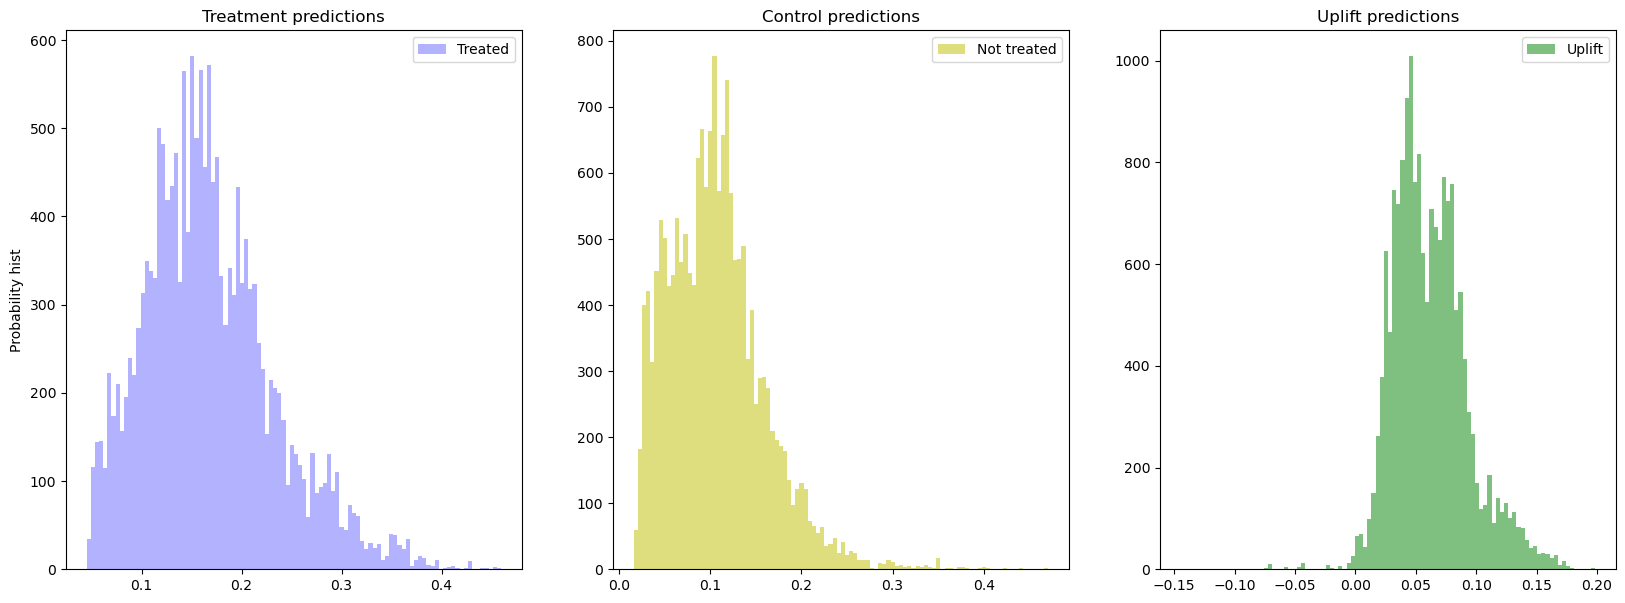

In [111]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [112]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,16.871059
1,treatment,16.402988
2,recency,14.670924
3,used_bogo,13.535927
4,history,11.030192
5,zip_code,9.762521
6,channel,8.903985
7,used_discount,8.822404


Трансформация классов

In [113]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

Две независимые модели

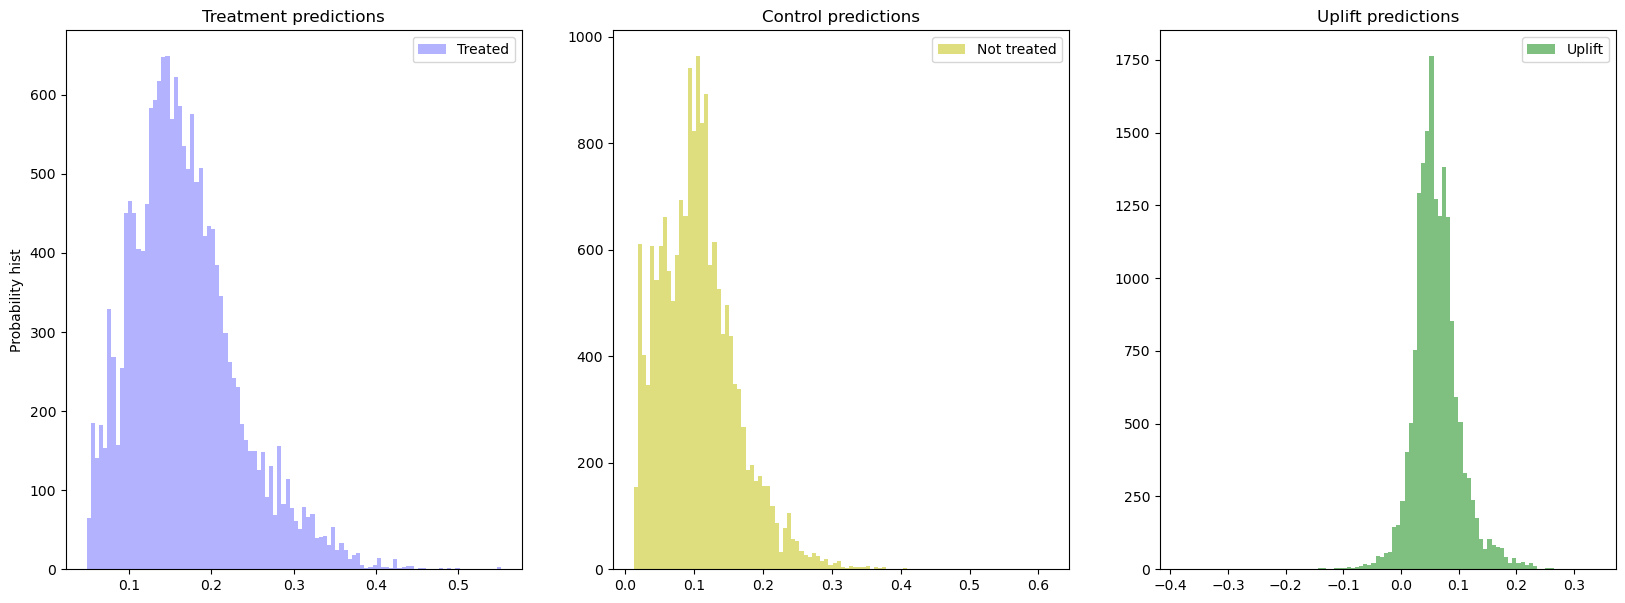

In [114]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [115]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
1,ClassTransformation,0.084331
0,SoloModel,0.075479
2,TwoModels,0.066741
